## MOBO

This exercise walks through the Multi objective Bayesian Optimization using the Toy Problem.



In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
# run only once during the notebook execution
!git clone https://github.com/cfteach/modules.git &> /dev/null
%pip install ax-platform &> /dev/null
%pip install ipyvolume &> /dev/null
%pip install plotly

In [3]:
%pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00


In [9]:
import ipyvolume as ipv
import ipywidgets as widgets

from IPython.display import display, Math, Latex


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2
import modules.detector2 as detector2
import re
import pickle
import dill

import torch

from ax.metrics.noisy_function import GenericNoisyFunctionMetric
from ax.service.utils.report_utils import exp_to_df  #https://ax.dev/api/service.html#ax.service.utils.report_utils.exp_to_df
from ax.runners.synthetic import SyntheticRunner

# Plotting imports and initialization
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
#init_notebook_plotting()

# Model registry for creating multi-objective optimization models.
from ax.modelbridge.registry import Models

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from ax import SumConstraint
from ax import OrderConstraint
from ax import ParameterConstraint
from ax.core.search_space import SearchSpace
from ax.core.parameter import RangeParameter,ParameterType

from ax.core.objective import MultiObjective, Objective, ScalarizedObjective
from ax.core.optimization_config import ObjectiveThreshold, MultiObjectiveOptimizationConfig

from ax.core.experiment import Experiment

from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from ax.core.data import Data

from ax.core.types import ComparisonOp

from sklearn.utils import shuffle
from functools import wraps


### Create detector geometry and simulate tracks  

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one.

A total of 8 parameters can be tuned.

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track.

So we want to maximize the efficiency (defined in detector.py) and minimize the cost.

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 0.0 0.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  20 , volume:  62.800000000000004
:::: TRACK GENERATION ::::


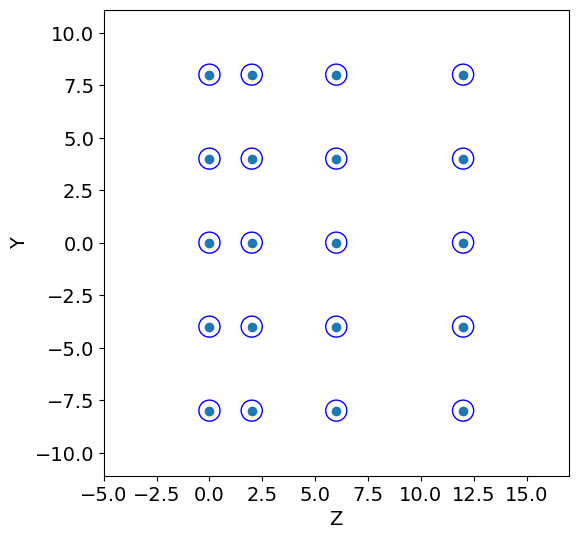

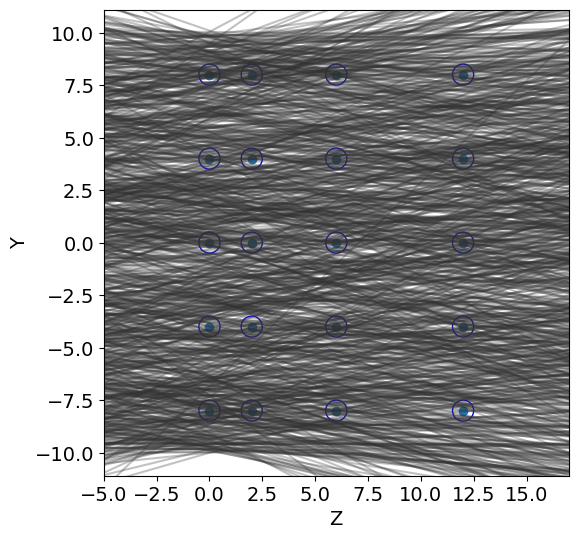

fraction of tracks detected:  0.264
resolution:  0.24613882479204957


In [10]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = .5
pitch = 4.0
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min=y_min, b_max=y_max, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("resolution: ",resolution)


---

### Define Objectives



Defines a class for the objectives of the problem that can be used in the MOO.  

In [11]:

class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."

      return res


  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res


  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)



...check:  62.800000000000004 0.264


---
### Multi-Objective Optimization

We will be using `ax-platform` (https://ax.dev).  

+ In this  example we will be using Multi-Objective Bayesian Optimization (MOBO) using qNEHVI + [SAASBO](https://proceedings.mlr.press/v161/eriksson21a.html)

+  

+ Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency

+ We add the resolution as a third objective.  The average residual of the track hit from the wire centre is used as a proxy for the resolution for this toy-model




In [12]:
#---------------------- BOTORCH FUNCTIONS ------------------------#

def build_experiment(search_space,optimization_config):
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def glob_fun(loc_fun):
    @wraps(loc_fun)
    def inner(xdic):
        x_sorted = [xdic[p_name] for p_name in xdic.keys()] #it assumes x will be given as, e.g., dictionary
        res = list(loc_fun(x_sorted))
        return res

    return inner

def initialize_experiment(experiment,N_INIT):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    experiment.new_batch_trial(sobol.gen(N_INIT)).run()

    return experiment.fetch_data()

@glob_fun
def ftot(xdic):
    return (1- res.get_score(xdic)[0], res.get_volume(), res.get_score(xdic)[1])

def f1(xdic):
    return ftot(xdic)[0] #obj1

def f2(xdic):
    return ftot(xdic)[1] #obj2

def f3(xdic):
    return ftot(xdic)[2] #obj3

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    }


# Define Hyper-parameters for the optimization
N_BATCH = 30
BATCH_SIZE = 5
dim_space = 8 # len(X)
N_INIT = 2 * (dim_space + 1) #
lowerv = np.array([0.5,2.5,0.,0.,0.,2.,2.,2.])
upperv = np.array([1.0,5.0,4.,4.,4.,10.,10.,10.])

In [ ]:
# defining the search space one can also include constraints in this function
search_space = SearchSpace(
    parameters=
    [RangeParameter(name=f"x{i}", lower=lowerv[i], upper=upperv[i],
                    parameter_type=ParameterType.FLOAT) for i in range(dim_space)]
    )
print (search_space)

# define the metrics for optimization
metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)
metric_c = GenericNoisyFunctionMetric("c", f=f3, noise_sd=0.0, lower_is_better=True)

mo = MultiObjective(objectives=[Objective(metric=metric_a),
                                Objective(metric=metric_b),
                                Objective(metric=metric_c)
                                ]
                    )

ref_point = [-1.1]*len(mo.metrics)
refpoints = torch.Tensor(ref_point).to(**tkwargs) # [1.1, 1.1, 1.1] for 3 objs

objective_thresholds = [ObjectiveThreshold(metric=metric, bound=val, relative=False, op=ComparisonOp.LEQ)
                        for metric, val in zip(mo.metrics, refpoints) #---> this requires defining a torch.float64 object --- by default is (-)1.1 for DTLZ
                        ]


optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds
    )

SearchSpace(parameters=[RangeParameter(name='x0', parameter_type=FLOAT, range=[0.5, 1.0]), RangeParameter(name='x1', parameter_type=FLOAT, range=[2.5, 5.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x3', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x4', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x5', parameter_type=FLOAT, range=[2.0, 10.0]), RangeParameter(name='x6', parameter_type=FLOAT, range=[2.0, 10.0]), RangeParameter(name='x7', parameter_type=FLOAT, range=[2.0, 10.0])], parameter_constraints=[])


In [ ]:
experiment = build_experiment(search_space,optimization_config)
data = initialize_experiment(experiment,N_INIT)

hv_list = []

for i in range(N_BATCH):
    print("\n\n...PROCESSING BATCH n.: {}\n\n".format(i+1))

    model = Models.FULLYBAYESIANMOO(
        experiment=experiment,
        data=data, # tell the data
        # use fewer num_samples and warmup_steps to speed up this tutorial
        num_samples=32,#256
        warmup_steps=64,#512
        torch_device=tkwargs["device"],
        verbose=False,  # Set to True to print stats from MCMC
        disable_progbar=False,  # Set to False to print a progress bar from MCMC
        )

    generator_run = model.gen(BATCH_SIZE)   #ask BATCH_SIZE points
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()
    data = Data.from_multiple_data([data, trial.fetch_data()])   #https://ax.dev/api/core.html#ax.Data.from_multiple_data

    print("\n\n\n...calculate df via exp_to_df (i.e., global dataframe so far):\n\n")


    metric_names = {index: i for index, i in enumerate(mo.metric_names)}
    N_METRICS = len(metric_names)
    df = exp_to_df(experiment).sort_values(by=["trial_index"])
    outcomes = torch.tensor(df[mo.metric_names].values)
    #outcomes, _ = data_to_outcomes(data, N_INIT, i+1, BATCH_SIZE, N_METRICS, metric_names)
    partitioning = DominatedPartitioning(ref_point=refpoints, Y=outcomes)
    try:
        hv = partitioning.compute_hypervolume().item()
    except:
        hv = 0
        print("Failed to compute hv")
    hv_list.append(hv)
    print(f"Iteration: {i+1}, HV: {hv}")



...PROCESSING BATCH n.: 1




Warmup:   0%|          | 0/96 [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/adaptation.py:235: UserWarning:

torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)

Sample: 100%|██████████| 96/96 [00:09, 10.52it/s, step size=3.04e-01, acc. prob=0.918]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 1, HV: 775.8981720991128


...PROCESSING BATCH n.: 2




Sample: 100%|██████████| 96/96 [00:09, 10.65it/s, step size=8.63e-01, acc. prob=0.393]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 2, HV: 780.8314594177796


...PROCESSING BATCH n.: 3




Sample: 100%|██████████| 96/96 [00:10,  9.14it/s, step size=4.31e-01, acc. prob=0.917]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 3, HV: 782.499707301615


...PROCESSING BATCH n.: 4




Sample: 100%|██████████| 96/96 [00:10,  9.34it/s, step size=4.91e-01, acc. prob=0.899]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 4, HV: 905.5592688743232


...PROCESSING BATCH n.: 5




Sample: 100%|██████████| 96/96 [00:09,  9.63it/s, step size=9.11e-01, acc. prob=0.432]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 5, HV: 908.4081724016958


...PROCESSING BATCH n.: 6




Sample: 100%|██████████| 96/96 [00:11,  8.15it/s, step size=2.50e-01, acc. prob=0.889]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 6, HV: 909.0676523262681


...PROCESSING BATCH n.: 7




Sample: 100%|██████████| 96/96 [00:12,  7.73it/s, step size=3.31e-01, acc. prob=0.805]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 7, HV: 909.0676523262681


...PROCESSING BATCH n.: 8




Sample: 100%|██████████| 96/96 [00:10,  8.86it/s, step size=4.60e-01, acc. prob=0.821]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 8, HV: 909.067652326268


...PROCESSING BATCH n.: 9




Sample: 100%|██████████| 96/96 [00:11,  8.60it/s, step size=4.35e-01, acc. prob=0.738]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 9, HV: 910.2284607950919


...PROCESSING BATCH n.: 10




Sample: 100%|██████████| 96/96 [00:13,  7.05it/s, step size=2.55e-01, acc. prob=0.927]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 10, HV: 914.8080081870806


...PROCESSING BATCH n.: 11




Sample: 100%|██████████| 96/96 [00:12,  7.73it/s, step size=4.30e-01, acc. prob=0.932]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 11, HV: 915.628790150333


...PROCESSING BATCH n.: 12




Sample: 100%|██████████| 96/96 [00:13,  6.86it/s, step size=3.51e-01, acc. prob=0.890]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 12, HV: 915.6442652844496


...PROCESSING BATCH n.: 13




Sample: 100%|██████████| 96/96 [00:19,  4.93it/s, step size=4.75e-01, acc. prob=0.873]
/usr/local/lib/python3.7/dist-packages/ax/service/utils/report_utils.py:406: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy






...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 13, HV: 915.7886523337578


...PROCESSING BATCH n.: 14




Sample: 100%|██████████| 96/96 [00:13,  7.16it/s, step size=4.04e-01, acc. prob=0.891]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 14, HV: 916.109049870694


...PROCESSING BATCH n.: 15




Sample: 100%|██████████| 96/96 [00:17,  5.55it/s, step size=4.52e-01, acc. prob=0.882]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 15, HV: 939.0174444317498


...PROCESSING BATCH n.: 16




Sample: 100%|██████████| 96/96 [00:19,  5.04it/s, step size=1.42e-01, acc. prob=0.930]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 16, HV: 939.0685541414773


...PROCESSING BATCH n.: 17




Sample: 100%|██████████| 96/96 [00:16,  5.86it/s, step size=2.51e-01, acc. prob=0.955]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 17, HV: 990.4607075978029


...PROCESSING BATCH n.: 18




Sample: 100%|██████████| 96/96 [00:16,  5.96it/s, step size=3.88e-01, acc. prob=0.949]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 18, HV: 990.4825437318023


...PROCESSING BATCH n.: 19




Sample: 100%|██████████| 96/96 [00:16,  5.69it/s, step size=3.06e-01, acc. prob=0.868]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 19, HV: 990.9026400899008


...PROCESSING BATCH n.: 20




Sample: 100%|██████████| 96/96 [00:18,  5.24it/s, step size=4.86e-01, acc. prob=0.909]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 20, HV: 990.9026400899006


...PROCESSING BATCH n.: 21




Sample: 100%|██████████| 96/96 [00:17,  5.35it/s, step size=4.42e-01, acc. prob=0.933]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 21, HV: 993.0093609295598


...PROCESSING BATCH n.: 22




Sample: 100%|██████████| 96/96 [00:22,  4.22it/s, step size=2.43e-01, acc. prob=0.958]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 22, HV: 995.4621211672672


...PROCESSING BATCH n.: 23




Sample: 100%|██████████| 96/96 [00:20,  4.63it/s, step size=3.83e-01, acc. prob=0.805]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 23, HV: 995.4873927732356


...PROCESSING BATCH n.: 24




Sample: 100%|██████████| 96/96 [00:22,  4.24it/s, step size=3.46e-01, acc. prob=0.612]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 24, HV: 998.270187641806


...PROCESSING BATCH n.: 25




Sample: 100%|██████████| 96/96 [00:22,  4.34it/s, step size=4.11e-01, acc. prob=0.754]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 25, HV: 999.2168246480121


...PROCESSING BATCH n.: 26




Sample: 100%|██████████| 96/96 [00:29,  3.22it/s, step size=2.89e-01, acc. prob=0.532]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 26, HV: 1000.8525442766024


...PROCESSING BATCH n.: 27




Sample: 100%|██████████| 96/96 [00:24,  3.95it/s, step size=3.15e-01, acc. prob=0.715]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 27, HV: 1000.8525442766022


...PROCESSING BATCH n.: 28




Sample: 100%|██████████| 96/96 [00:32,  2.91it/s, step size=1.37e-01, acc. prob=0.947]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 28, HV: 1001.3069085950718


...PROCESSING BATCH n.: 29




Sample: 100%|██████████| 96/96 [00:26,  3.58it/s, step size=3.20e-01, acc. prob=0.920]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 29, HV: 1001.3069085950717


...PROCESSING BATCH n.: 30




Sample: 100%|██████████| 96/96 [00:32,  2.99it/s, step size=2.21e-01, acc. prob=0.967]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 30, HV: 1001.3069085950717


### Analysis of Results

### Inspecting the Hyper volume statistics

In [ ]:
import plotly.express as px

fig = px.scatter(x = np.arange(N_BATCH) + 1, y = hv_list,
           labels={"x": "N_BATCHES",
                    "y": "Hyper Volume"},
           width = 800, height = 800,
           title = "HyperVolume Improvement", )
fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='marker+line'))
fig.data[0].update(mode = "markers+lines")
fig.show()



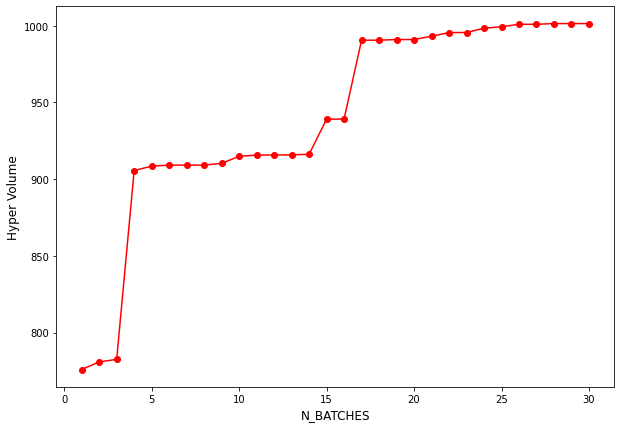

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 7))
plt.plot(np.arange(N_BATCH) + 1 , hv_list, "ro-")
plt.xlabel("N_BATCHES", fontsize = 12)
plt.ylabel("Hyper Volume", fontsize = 12)
plt.show()

### Overall Performance in the Objective space.

In [ ]:
fig1 = px.scatter_3d(df, x="a", y="b", z = "c", color = "trial_index",
                     labels = { "a": "InEfficiency",
                               "b": "Volume",
                               "c": "Resolution"
                     }, hover_data = df.columns,
                     height = 800, width = 800)
fig1.show()

### Exploration as a function of Iteration number


In [ ]:
obj_fig = px.scatter_3d(df, x="a", y="b", z = "c", animation_frame="trial_index", color="trial_index",
                        range_x=[0., 0.6], range_y=[0. , 400.], range_z=[0., 0.6],
                     labels = { "a": "InEfficiency",
                               "b": "Volume",
                               "c": "Resolution"}, hover_data = df.columns,
                        width = 800, height = 800)
obj_fig.update(layout_coloraxis_showscale=False)
obj_fig.show()

### Computing posterior pareto frontiers.

Once can sample expected approximate pareto front solution from the built surrogate model.


In [ ]:
from ax.core import metric


# https://ax.dev/api/plot.html#ax.plot.pareto_utils.compute_posterior_pareto_frontier

# absolute_metrics – List of outcome metrics that should NOT be relativized w.r.t. the status quo
# (all other outcomes will be in % relative to status_quo).

# Note that approximated pareto frontier is can be visualized only against 2 objectives.
# So one can try to make mixed plots, to see the ``

n_points_surrogate = 25
frontier = [] #(a,b), (a,c), (b,c)
metric_combos = [(metric_a, metric_b), (metric_a, metric_c), (metric_b, metric_c)]

for combo in metric_combos:
    print ("computing pareto frontier : ", combo)
    frontier.append(compute_posterior_pareto_frontier(
        experiment=experiment,
        data=experiment.fetch_data(),
        primary_objective=combo[0], #_b
        secondary_objective=combo[1], #_a
        absolute_metrics=["a", "b", "c"],
        num_points=n_points_surrogate,
    ))

#render(plot_pareto_frontier(frontier, CI_level=0.9))
#res_front = plot_pareto_frontier(frontier, CI_level=0.8)



computing pareto frontier :  (GenericNoisyFunctionMetric('a'), GenericNoisyFunctionMetric('b'))
computing pareto frontier :  (GenericNoisyFunctionMetric('a'), GenericNoisyFunctionMetric('c'))
computing pareto frontier :  (GenericNoisyFunctionMetric('b'), GenericNoisyFunctionMetric('c'))


In [ ]:
print ("Metric_a, Metric_b")
render(plot_pareto_frontier(frontier[0], CI_level=0.8))

Metric_a, Metric_b


In [ ]:
print ("Metric_a, Metric_c")
render(plot_pareto_frontier(frontier[1], CI_level=0.8))

Metric_a, Metric_c


In [ ]:
print ("Metric_b, Metric_c")
render(plot_pareto_frontier(frontier[2], CI_level=0.8))

Metric_b, Metric_c


### Validating the computed pareto front performance

Since the model is trained on objectives, One can perform `k-fold` validation to see the performance of the surrgoate model's prediction

In [ ]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import tile_cross_validation

#https://ax.dev/api/_modules/ax/modelbridge/cross_validation.html

cv = cross_validate(model, folds = 5)
render(tile_cross_validation(cv))